<a href="https://colab.research.google.com/github/petergchang/pyprobml/blob/master/notebooks/book2/15/adf_logistic_regression_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Online Logistic Regression using ADF

Online training of a logistic regression model using Assumed Density Filtering (ADF).

We compare the ADF result with Laplace approximation of the posterior.

For further details, see the ADF paper:
O. Zoeter, "Bayesian Generalized Linear Models in a Terabyte World," 2007 5th International Symposium on Image and Signal Processing and Analysis, 2007, pp. 435-440, doi: 10.1109/ISPA.2007.4383733.

Authors: Peter G. Chang ([@petergchang](https://github.com/petergchang)), Gerardo Durán-Martín ([@gerdm](https://github.com/gerdm))

## 0. Imports

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.scipy.stats import norm
from jax import vmap
from jax import lax

##1. Simulation and Plotting

We generate a reasonable 2d binary classification data.

In [243]:
def generate_dataset(num_points=1000, shuffle=True, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key0, key1, key2 = jr.split(key, 3)

    # Generate standardized noisy inputs that correspond to output '0'
    num_zero_points = num_points // 2
    zero_input = jnp.array([[-1., -1.]] * num_zero_points)
    zero_input += jr.normal(key0, (num_zero_points, 2))

    # Generate standardized noisy inputs that correspond to output '1'
    num_one_points = num_points - num_zero_points
    one_input = jnp.array([[1., 1.]] * num_one_points)
    one_input += jr.normal(key1, (num_one_points, 2))

    # Stack the inputs and add bias term
    input = jnp.concatenate([zero_input, one_input])
    input_with_bias = jnp.concatenate([jnp.ones((num_points, 1)), input], axis=1)

    # Generate binary output
    output = jnp.concatenate([jnp.zeros((num_zero_points)), jnp.ones((num_one_points))])

    # Shuffle
    if shuffle:
        idx = jr.shuffle(key2, jnp.arange(num_points))
        input, input_with_bias, output = input[idx], input_with_bias[idx], output[idx]
    
    return input, input_with_bias, output

In [244]:
# Generate data
input, input_with_bias, output = generate_dataset()

/usr/local/lib/python3.7/dist-packages/jax/_src/random.py:372: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


Next, we define a function that visualizes the 2d posterior predictive distribution.

In [245]:
def plot_posterior_predictive(ax, X, title, colors, Xspace=None, Zspace=None, cmap="viridis"):
    if Xspace is not None and Zspace is not None:
        ax.contourf(*Xspace, Zspace, cmap=cmap, levels=20)
        ax.axis('off')
    ax.scatter(*X.T, c=colors, edgecolors='gray', s=50)
    ax.set_title(title)
    plt.tight_layout()

In [246]:
def plot_boundary(ax, X, colors, Xspace, w):
    ax.scatter(*X.T, c=colors, edgecolors='gray', s=50)
    ax.plot(Xspace[0], -w[1]/w[2] * Xspace[0] - w[0]/w[2])
    plt.tight_layout()

Let's look at our binary data in 2d.

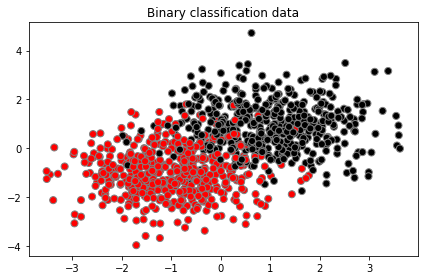

In [247]:
fig, ax = plt.subplots()

title = "Binary classification data"
colors = ['black' if y else 'red' for y in output]
plot_posterior_predictive(ax, input, title, colors )

Let us define a grid on which we compute the predictive distribution.

In [248]:
# Define grid limits
xmin, ymin = input.min(axis=0) - 0.1
xmax, ymax = input.max(axis=0) + 0.1

# Define grid
step = 0.1
input_grid = jnp.mgrid[xmin:xmax:step, ymin:ymax:step]
_, nx, ny = input_grid.shape
input_with_bias_grid = jnp.concatenate([jnp.ones((1, nx, ny)), input_grid])

Next, we define a function to that returns the posterior predictive probability for each point in grid.

In [249]:
def posterior_predictive_grid(grid, mean, cov, n_samples=5000, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    samples = jax.random.multivariate_normal(key, mean, cov, (n_samples,))
    Z = jax.nn.sigmoid(jnp.einsum("mij,sm->sij", grid, samples))
    Z = Z.mean(axis=0)
    return Z

Also, we define a function that prints and plots the final ADF estimate of the weights.

In [250]:
def show_adf_estimate(means, vars):
    print(f"ADF estimate weights: {means}")

    # ** Plotting predictive distribution **
    fig, ax = plt.subplots()
    for i in range(len(means)):
        mean, std = means[i], jnp.sqrt(vars[i])
        ax = fig.gca()
        x = jnp.linspace(mean - 4 * std, mean + 4 * std, 500)
        ax.plot(x, norm.pdf(x, mean, std), label="posterior (ADF)", linestyle="dashdot")
        ax.legend()

Finally, we define a function that plots the convergence of filtered estimates to Laplace batch estimate.

In [251]:
def plot_adf_post_laplace(
    mu_hist, tau_hist, w_fix, lcolors, label, legend_font_size=12, bb1=(1.1, 1.1), bb2=(1, 0.3), bb3=(0.6, 0.3)
):

    elements = (mu_hist.T, tau_hist.T, w_fix, lcolors)
    n_datapoints = len(mu_hist)
    timesteps = jnp.arange(n_datapoints) + 1

    for k, (wk, Pk, wk_fix, c) in enumerate(zip(*elements)):
        fig_weight_k, ax = plt.subplots()
        ax.errorbar(timesteps, wk, jnp.sqrt(Pk), c=c, label=f"$w_{k}$ online (adf)")
        ax.axhline(y=wk_fix, c=c, linestyle="dotted", label=f"$w_{k}$ batch (Laplace)", linewidth=3)

        ax.set_xlim(1, n_datapoints)

        ax.set_xlabel("number samples", fontsize=15)
        ax.set_ylabel("weights", fontsize=15)
        ax.tick_params(axis="both", which="major", labelsize=15)
        sns.despine()
        if k == 0:
            ax.legend(frameon=False, loc="upper right", bbox_to_anchor=bb1, fontsize=legend_font_size)

        elif k == 1:
            ax.legend(frameon=False, bbox_to_anchor=bb2, fontsize=legend_font_size)

        elif k == 2:
            ax.legend(frameon=False, bbox_to_anchor=bb3, fontsize=legend_font_size)

        plt.tight_layout()
        pml.savefig(label.format(k=k))
        plt.savefig(label.format(k=k) + ".pdf", bbox_inches="tight", pad_inches=0.0)

##2. Laplace Estimate

We compute the Laplace-approximation posterior for comparison.

In [252]:
def log_posterior(w, X, Y, prior_var):
    prediction = jax.nn.sigmoid(X @ w)
    log_prior = -(prior_var * w @ w / 2)
    log_likelihood = Y * jnp.log(prediction) + (1 - Y) * jnp.log(1 - prediction)
    return log_prior + log_likelihood.sum()

def laplace_inference(X, Y, prior_var=2.0, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    input_dim = X.shape[-1]

    # Initial random guess
    w0 = jr.multivariate_normal(key, jnp.zeros(input_dim), jnp.eye(input_dim) * prior_var)
    
    # Energy function to minimize
    E = lambda w: -log_posterior(w, X, Y, prior_var) / len(Y)

    # Minimize energy function
    w_laplace = minimize(E, w0, method="BFGS").x
    cov_laplace = jax.hessian(E)(w_laplace)

    return w_laplace, cov_laplace

In [253]:
# Compute Laplace posterior
prior_var = 2.0
w_laplace, cov_laplace = laplace_inference(input_with_bias, output, prior_var=prior_var)

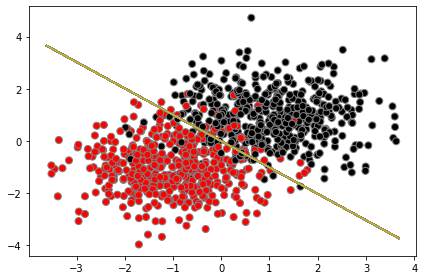

In [254]:
fig_adf, ax = plt.subplots()

plot_boundary(ax, input, colors, input_grid, w_laplace)

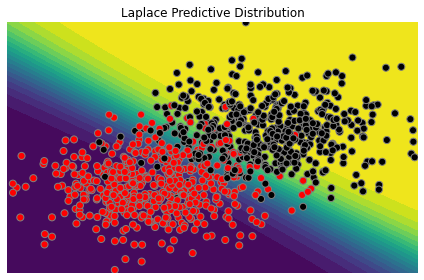

In [255]:
fig_adf, ax = plt.subplots()

# Plot Laplace posterior predictive distribution
Z_laplace = posterior_predictive_grid(input_with_bias_grid, w_laplace, cov_laplace)
title = "Laplace Predictive Distribution"
plot_posterior_predictive(ax, input, title, colors, input_grid, Z_laplace)

##3. ADF Estimates

First we define the sigma-point numerical integration to be used by the update step for ADF.

In [256]:
def compute_weights_and_sigmas_1d(m, P, alpha=jnp.sqrt(3), beta=2, kappa=1):
    lamb = alpha**2 * (1 + kappa) - 1
    # Compute weights
    factor = 1 / (2 * (1 + lamb))
    w_mean = jnp.concatenate((jnp.array([lamb / (1 + lamb)]), jnp.ones(2) * factor))
    w_cov = jnp.concatenate((jnp.array([lamb / (1 + lamb) + (1 - alpha**2 + beta)]), 
                             jnp.ones(2) * factor))
    # Compute sigmas
    distances = jnp.sqrt(1 + lamb) * jnp.sqrt(P)
    sigma_plus = jnp.array([m + distances])
    sigma_minus = jnp.array([m - distances])
    sigmas = jnp.concatenate((jnp.array([m]), sigma_plus, sigma_minus))
    return w_mean, w_cov, sigmas

def sigma_point_gaussian_expectation_1d(f, m, P):
    w_mean, _, sigmas = compute_weights_and_sigmas_1d(m, P)
    return jnp.atleast_1d(jnp.tensordot(w_mean, vmap(f)(sigmas), axes=1))

Next, we can construct a 1d logistic regression ADF.

In [257]:
def adf_1d_logistic_regression(initial_means, initial_vars, inputs, emissions, drift=0):
    num_timesteps = len(emissions)

    def likelihood(y, eta):
        prediction = jax.nn.sigmoid(eta)
        return jnp.where(y, prediction, 1 - prediction)

    def _step(carry, t):
        prior_means, prior_vars = carry
        x, y = inputs[t], emissions[t]

        # Prediction step
        pred_means = prior_means
        pred_vars = prior_vars + drift

        # Update step
        cond_eta_mean = x @ pred_means
        cond_eta_var = x**2 @ pred_vars

        # Perform numerical integration
        Zt = sigma_point_gaussian_expectation_1d(
            lambda eta: likelihood(y, eta), cond_eta_mean, cond_eta_var
        )
        post_eta_mean = sigma_point_gaussian_expectation_1d(
            lambda eta: eta / Zt * likelihood(y, eta), cond_eta_mean, cond_eta_var
        )
        post_eta_var = sigma_point_gaussian_expectation_1d(
            lambda eta: eta**2 / Zt * likelihood(y, eta), cond_eta_mean, cond_eta_var
        ) - post_eta_mean**2
        # Estimate posterior
        mean_diff = post_eta_mean - cond_eta_mean
        var_diff = post_eta_var - cond_eta_var
        
        weight = x * pred_vars / (x**2 + pred_vars).sum()
        post_means = pred_means + weight * mean_diff
        post_vars = pred_vars + weight**2 * var_diff

        return (post_means, post_vars), (post_means, post_vars)
    
    carry = (initial_means, initial_vars)
    (post_means, post_vars), (means_hist, vars_hist) = lax.scan(_step, carry, jnp.arange(num_timesteps))

    return (post_means, post_vars), (means_hist, vars_hist)

In [258]:
num_dims = input_with_bias.shape[-1]

# Run ADF
(post_means, post_vars), (means_hist, vars_hist) = adf_1d_logistic_regression(
    initial_means = jnp.zeros(num_dims),
    initial_vars = jnp.ones(num_dims),
    inputs = input_with_bias,
    emissions = output
)

ADF estimate weights: [-0.02906595  2.0735168   2.0495355 ]


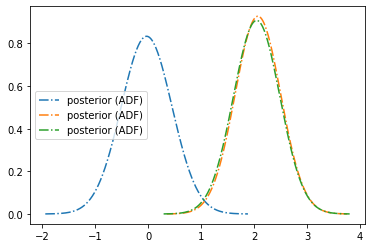

In [259]:
show_adf_estimate(post_means, post_vars)

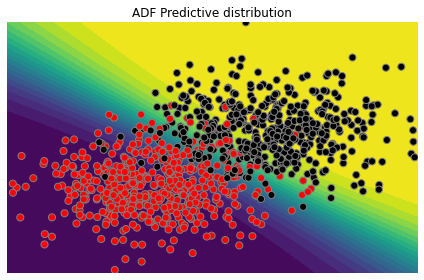

In [260]:
fig_adf, ax = plt.subplots()

# ADF posterior predictive distribution
Z_adf = posterior_predictive_grid(input_with_bias_grid, post_means, jnp.diag(post_vars))
title = "ADF Predictive distribution"
plot_posterior_predictive(ax, input, title, colors, input_grid, Z_adf)

##4. Inference over Time

Finally, we will look at the convergence of the ADF-inferred weights to the Laplace batch estimate.

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


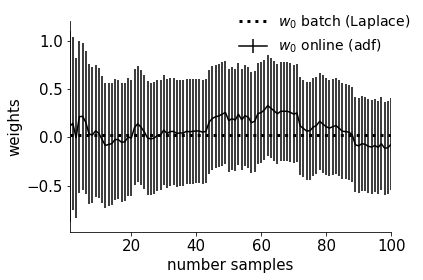

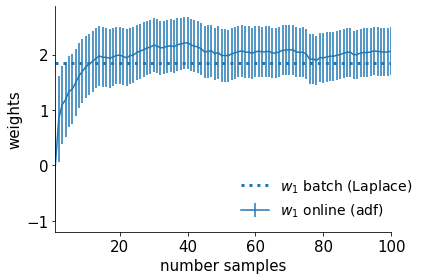

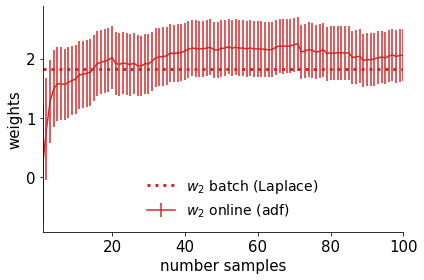

In [261]:
lcolors = ["black", "tab:blue", "tab:red"]
plot_adf_post_laplace(
    means_hist[::max(1, len(output)//100)], vars_hist[::max(1, len(output)//100)], w_laplace, lcolors, label, legend_font_size=14, bb2=(1.1, 0.3), bb3=(0.8, 0.3)
)

In [9]:
# Online training of a logistic regression model
# using Assumed Density Filtering (ADF).
# We compare the ADF result with MCMC sampling
# For further details, see the ADF paper:
#   * O. Zoeter, "Bayesian Generalized Linear Models in a Terabyte World,"
#     2007 5th International Symposium on Image and Signal Processing and Analysis, 2007,
#     pp. 435-440, doi: 10.1109/ISPA.2007.4383733.
# of the posterior distribution

# Author: Peter G. Chang (@petergchang) and Gerardo Durán-Martín (@gerdm)
import os
import jax
import numpy as np
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from functools import partial
from jax.scipy.stats import norm
from jax.scipy.optimize import minimize
from jax import vmap
import seaborn as sns

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

In [6]:
from probml_utils import savefig, latexify

# os.environ["LATEXIFY"] = ""
# os.environ["FIG_DIR"] = "figures"
# latexify(width_scale_factor=3, fig_height=1.5)  # for book

$$
    \eta_t = \sigma({\bf w}_t^T {\bf x}_t) + q_t; q_t \sim \mathcal{N}(0, v_t)
$$

$$
    p({\bf w}_t \vert {\bf w}_{t-1}) = \prod_j\mathcal{N}(w_t^j \vert  \mu_{t \vert t-1}, \tau_{t \vert t-1}^j)
$$

In [50]:
def compute_weights_and_sigmas_1d(m, P, alpha=jnp.sqrt(3), beta=2, kappa=1):
    lamb = alpha**2 * (1 + kappa) - 1
    # Compute weights
    factor = 1 / (2 * (1 + lamb))
    w_mean = jnp.concatenate((jnp.array([lamb / (1 + lamb)]), jnp.ones(2) * factor))
    w_cov = jnp.concatenate((jnp.array([lamb / (1 + lamb) + (1 - alpha**2 + beta)]), 
                             jnp.ones(2) * factor))
    # Compute sigmas
    distances = jnp.sqrt(1 + lamb) * jnp.sqrt(P)
    sigma_plus = jnp.array([m + distances])
    sigma_minus = jnp.array([m - distances])
    sigmas = jnp.concatenate((jnp.array([m]), sigma_plus, sigma_minus))
    return w_mean, w_cov, sigmas

def sigma_point_gaussian_expectation_1d(f, m, P):
    w_mean, _, sigmas = compute_weights_and_sigmas_1d(m, P)
    return jnp.atleast_1d(jnp.tensordot(w_mean, vmap(f)(sigmas), axes=1))

In [51]:
# def h(n, a, b):
#     return (b - a) / 2**n


# def romb_row_init(R_prev: float, n: int, a: int, b: int, f):
#     k_points = jnp.arange(1, 2 ** (n - 1) + 1)
#     eval_points = a + (2 * k_points - 1) * h(n, a, b)
#     R_init = R_prev / 2 + h(n, a, b) * f(eval_points).sum()

#     return R_init


# def romb(f, a, b, n_iterations=4):
#     """
#     O(x^2) implementation of Romberg's method.
#     Reference: https://en.wikipedia.org/wiki/Romberg%27s_method
#     """
#     R_values = jnp.zeros((n_iterations + 1, n_iterations + 1))

#     R = h(1, a, b) * (f(a) + f(b))
#     R_values = R_values.at[0, 0].set(R)

#     for n in range(1, n_iterations + 1):
#         R = romb_row_init(R_values[n - 1, 0], n, a, b, f)
#         R_values = R_values.at[n, 0].set(R)

#         for m in range(1, n + 1):
#             R = (4**m * R_values[n, m - 1] - R_values[n - 1, m - 1]) / (4**m - 1)
#             R_values = R_values.at[n, m].set(R)
#     I = R_values[-1, -1]
#     return I

In [52]:
def Zt_func(eta, y, mu, v):
    log_term = y * jax.nn.log_sigmoid(eta) + (1 - y) * jnp.log1p(-jax.nn.sigmoid(eta))
    log_term = log_term + norm.logpdf(eta, mu, v)

    return jnp.exp(log_term)


def mt_func(eta, y, mu, v, Zt):
    log_term = y * jax.nn.log_sigmoid(eta) + (1 - y) * jnp.log1p(-jax.nn.sigmoid(eta))
    log_term = log_term + norm.logpdf(eta, mu, v)

    return eta * jnp.exp(log_term) / Zt


def vt_func(eta, y, mu, v, Zt):
    log_term = y * jax.nn.log_sigmoid(eta) + (1 - y) * jnp.log1p(-jax.nn.sigmoid(eta))
    log_term = log_term + norm.logpdf(eta, mu, v)

    return eta**2 * jnp.exp(log_term) / Zt


# def adf_step(state, xs, prior_variance, lbound, ubound):
#     mu_t, tau_t = state
#     Phi_t, y_t = xs

#     mu_t_cond = mu_t
#     tau_t_cond = tau_t + prior_variance

#     # prior predictive distribution
#     m_t_cond = (Phi_t * mu_t_cond).sum()
#     v_t_cond = (Phi_t**2 * tau_t_cond).sum()

#     v_t_cond_sqrt = jnp.sqrt(v_t_cond)

#     # Moment-matched Gaussian approximation elements
#     Zt = romb(lambda eta: Zt_func(eta, y_t, m_t_cond, v_t_cond_sqrt), lbound, ubound)

#     mt = romb(lambda eta: mt_func(eta, y_t, m_t_cond, v_t_cond_sqrt, Zt), lbound, ubound)

#     vt = romb(lambda eta: vt_func(eta, y_t, m_t_cond, v_t_cond_sqrt, Zt), lbound, ubound)
#     vt = vt - mt**2

#     # Posterior estimation
#     delta_m = mt - m_t_cond
#     delta_v = vt - v_t_cond
#     a = Phi_t * tau_t_cond / (Phi_t**2 + tau_t_cond).sum()

#     mu_t = mu_t_cond + a * delta_m
#     tau_t = tau_t_cond + a**2 * delta_v

#     return (mu_t, tau_t), (mu_t, tau_t)

In [53]:
def adf_step(state, xs, prior_variance):
    mu_t, tau_t = state
    Phi_t, y_t = xs

    mu_t_cond = mu_t
    tau_t_cond = tau_t + prior_variance

    # prior predictive distribution
    m_t_cond = (Phi_t * mu_t_cond).sum()
    v_t_cond = (Phi_t**2 * tau_t_cond).sum()

    v_t_cond_sqrt = jnp.sqrt(v_t_cond)

    # Moment-matched Gaussian approximation elements
    Zt = sigma_point_gaussian_expectation_1d(lambda eta: Zt_func(eta, y_t, m_t_cond, v_t_cond_sqrt), m_t_cond, v_t_cond)
    mt = sigma_point_gaussian_expectation_1d(lambda eta: mt_func(eta, y_t, m_t_cond, v_t_cond_sqrt, Zt), m_t_cond, v_t_cond)
    vt = sigma_point_gaussian_expectation_1d(lambda eta: vt_func(eta, y_t, m_t_cond, v_t_cond_sqrt, Zt), m_t_cond, v_t_cond) - mt**2

    # Posterior estimation
    delta_m = mt - m_t_cond
    delta_v = vt - v_t_cond
    a = Phi_t * tau_t_cond / (Phi_t**2 + tau_t_cond).sum()

    mu_t = mu_t_cond + a * delta_m
    tau_t = tau_t_cond + a**2 * delta_v

    return (mu_t, tau_t), (mu_t, tau_t)

## Initial setup

In [55]:
key = jax.random.PRNGKey(314)
key_pp, key_shuffle, key = jax.random.split(key, 3)
X, Phi, y = generate_dataset()
n_datapoints = len(y)

/usr/local/lib/python3.7/dist-packages/jax/_src/random.py:372: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


In [56]:
# Predictive domain
xmin, ymin = X.min(axis=0) - 0.1
xmax, ymax = X.max(axis=0) + 0.1
step = 0.1
Xspace = jnp.mgrid[xmin:xmax:step, ymin:ymax:step]
_, nx, ny = Xspace.shape
Phispace = jnp.concatenate([jnp.ones((1, nx, ny)), Xspace])

## ADF Inference

In [59]:
prior_variance = 0.00

n_datapoints, ndims = Phi.shape
lbound, ubound = -12.0, 12.0
mu_0 = jnp.zeros(ndims) * 0.0
tau_0 = jnp.ones(ndims) * 1.0

init_state = (mu_0, tau_0)

### Run with shuffled data

ADF weights
[0.00734098 0.1771524  0.18702908]


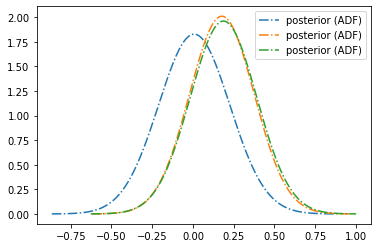

In [60]:
xs = (Phi, y)
colors = ["black" if el else "red" for el in y]

adf_loop = partial(adf_step, prior_variance=prior_variance)
(mu_t, tau_t), (mu_t_hist, tau_t_hist) = jax.lax.scan(adf_loop, init_state, xs)
print("ADF weights")
print(mu_t)

# ** Plotting predictive distribution **
fig, ax = plt.subplots()
for i in range(ndims):
    mean, std = mu_t[i], jnp.sqrt(tau_t[i])
    ax = fig.gca()
    x = jnp.linspace(mean - 4 * std, mean + 4 * std, 500)
    ax.plot(x, norm.pdf(x, mean, std), label="posterior (ADF)", linestyle="dashdot")
    ax.legend()

### ADF predictive distribution

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


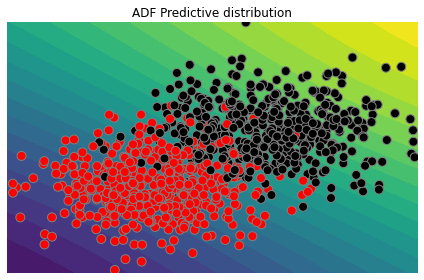

In [61]:
fig_adf, ax = plt.subplots()

# ADF posterior predictive distribution
Z_adf = sample_posterior_predictive2d(key_pp, Phispace, mu_t, jnp.diag(tau_t))
title = "ADF Predictive distribution"
plot_posterior_predictive(ax, X, Xspace, Z_adf, title, colors, cmap="viridis")
pml.savefig("logistic_regression_surface_adf.pdf")

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


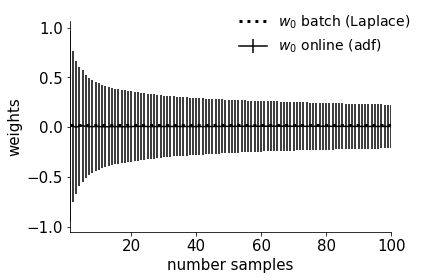

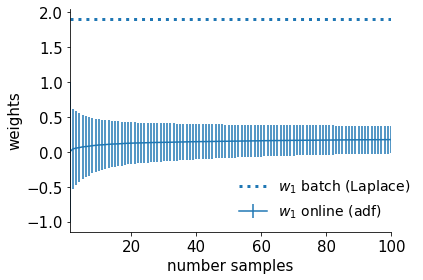

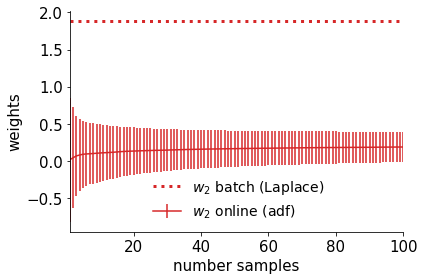

In [62]:
lcolors = ["black", "tab:blue", "tab:red"]
label = "logistic_regression_hist_adf_w{k}"
plot_adf_post_laplace(
    mu_t_hist[::max(1, len(y)//100)], tau_t_hist[::max(1, len(y)//100)], w_laplace, lcolors, label, legend_font_size=14, bb2=(1.1, 0.3), bb3=(0.8, 0.3)
)

# Save

In [64]:
!zip -q -r /content/adf-figures.zip /content/adf-figures


zip error: Nothing to do! (try: zip -q -r /content/adf-figures.zip . -i /content/adf-figures)
